In [2]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.mask import mask
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.optim import SGD
import matplotlib.pyplot as plt
from rasterio.plot import show

In [3]:
# Define the Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MLP model using Swish
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(8, 64)  # Example layer, adjust dimensions as needed
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 5)  # Output layer for 5 classes
        self.swish = Swish()

    def forward(self, x):
        x = self.swish(self.fc1(x))
        x = self.swish(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
# Load and process Planetscope data
data = "./Data/planetscope.tif"
full_dataset = rasterio.open(data)
img_bands = full_dataset.count
print(full_dataset.shape)  # dimensi kolom baris
print(full_dataset.count)  # jumlah saluran



(1570, 1690)
8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1570, 1690)


<Axes: >

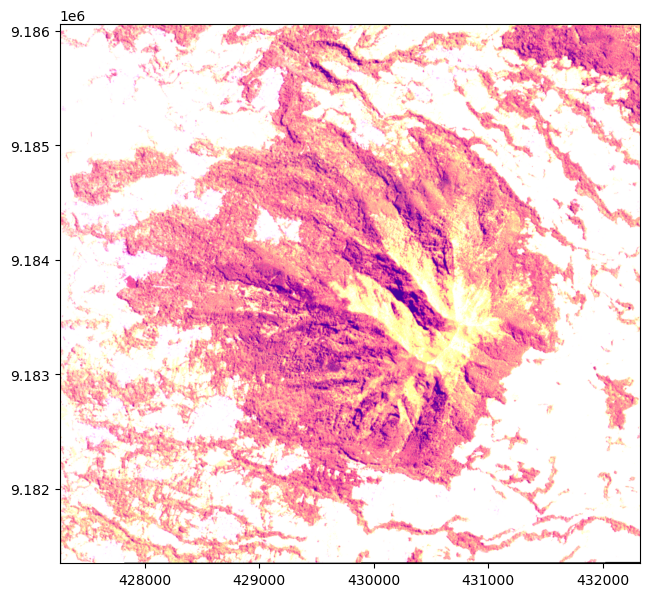

In [5]:
# Plot data dengan koordinat citra
img = full_dataset.read([4, 3, 2])
print(img.shape)
fig, ax = plt.subplots(figsize=(10, 7))
show(img[:, :, :], ax=ax, transform=full_dataset.transform)


In [6]:
# Load shapefile
shapefile = gpd.read_file('./Data/landcover.shp')
len(shapefile)
geoms = shapefile.geometry.values

In [7]:
# Clip and mask the dataset
geometry = geoms[0]
feature = [mapping(geometry)]
out_image, out_transform = mask(full_dataset, feature, crop=True)
print(out_image.shape)
print(out_transform)

(8, 8, 10)
| 3.00, 0.00, 430215.00|
| 0.00,-3.00, 9183429.00|
| 0.00, 0.00, 1.00|


In [8]:
# Prepare image and class label data for training
def str_class_to_int(class_array):
    class_array[class_array == 'semak'] = 0
    class_array[class_array == 'hutan'] = 1
    class_array[class_array == 'permukiman'] = 2
    class_array[class_array == 'bareland'] = 3
    class_array[class_array == 'pertanian'] = 4
    return class_array.astype(int)

X = np.array([], dtype=np.int32).reshape(0, 8)  # pixels for training
y = np.array([], dtype=np.int32)  # labels for training

with rasterio.open(data) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]
        out_image, out_transform = mask(src, feature, crop=True)
        out_image_trimmed = out_image[:, ~np.all(out_image == 0, axis=0)]
        out_image_trimmed = out_image_trimmed[:, ~np.all(out_image_trimmed == 255, axis=0)]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        y = np.append(y, [shapefile["Kelas"][index]] * out_image_reshaped.shape[0])
        X = np.vstack((X, out_image_reshaped))

In [9]:
# What are our classification labels?
labels = np.unique(shapefile["Kelas"])
print(f'The training data include {labels.size} classes: {labels}')
print(f'Our X matrix is sized: {X.shape}')
print(f'Our y array is sized: {y.shape}')

The training data include 5 classes: ['bareland' 'hutan' 'permukiman' 'pertanian' 'semak']
Our X matrix is sized: (20853, 8)
Our y array is sized: (20853,)


In [10]:
# Convert class labels from string to integer and show feature matrix
y = str_class_to_int(y)
print(X)
print(np.unique(y))

[[   1    1    1 ...    1    1    1]
 [   1    1    1 ...    1    1    1]
 [   1    1    1 ...    1    1    1]
 ...
 [4566 4540 4429 ... 4137 4431 4472]
 [4550 4589 4375 ... 4227 4557 4627]
 [4546 4335 4394 ... 4596 4493 4368]]
[0 1 2 3 4]


In [11]:
# Generate batch data
def next_batch(inputs, targets, batchSize):
    for i in range(0, inputs.shape[0], batchSize):
        yield (inputs[i:i + batchSize], targets[i:i + batchSize])

In [12]:
# Set batch size, epoch, learning rate
BATCH_SIZE = 128
EPOCH = 1000
LR = 1e-4

In [13]:
# Set processing device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] training using {DEVICE} ...")

[INFO] training using cpu ...


In [14]:
# Split data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.15, random_state=95)
trainX = torch.from_numpy(trainX).float()
testX = torch.from_numpy(testX).float()
trainY = torch.from_numpy(trainY).float()
testY = torch.from_numpy(testY).float()

In [15]:
# Define and initialize the MLP model
mlp = MLP()
mlp = mlp.to(DEVICE)
print(mlp)

MLP(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
  (swish): Swish()
)


In [16]:
# Define optimizer and loss function
opt = SGD(mlp.parameters(), lr=LR)
lossFunc = nn.CrossEntropyLoss()

In [17]:
# Train the model
loss_train_hist = []
loss_test_hist = []
accuracy_train_hist = []
accuracy_test_hist = []

for epoch in range(0, EPOCH):
    print(f"[INFO] epoch: {epoch + 1}...")
    trainLoss = 0
    trainAcc = 0
    samples = 0
    mlp.train()

    for (batchX, batchY) in next_batch(trainX, trainY, BATCH_SIZE):
        (batchX, batchY) = (batchX.to(DEVICE), batchY.to(DEVICE))
        predictions = mlp(batchX)
        loss = lossFunc(predictions, batchY.long())
        opt.zero_grad()
        loss.backward()
        opt.step()
        trainLoss += loss.item() * batchY.size(0)
        trainAcc += (predictions.max(1)[1] == batchY).sum().item()
        samples += batchY.size(0)
        loss_train_hist.append(trainLoss / samples)
        accuracy_train_hist.append(trainAcc / samples)

    print(f"epoch: {epoch + 1} train loss: {trainLoss / samples:.3f} train accuracy: {trainAcc / samples:.3f}")

    # Testing phase
    testLoss = 0
    testAcc = 0
    samples = 0
    mlp.eval()
    with torch.no_grad():
        for (batchX, batchY) in next_batch(testX, testY, BATCH_SIZE):
            (batchX, batchY) = (batchX.to(DEVICE), batchY.to(DEVICE))
            predictions = mlp(batchX)
            loss = lossFunc(predictions, batchY.long())
            testLoss += loss.item() * batchY.size(0)
            testAcc += (predictions.max(1)[1] == batchY).sum().item()
            samples += batchY.size(0)

            loss_test_hist.append(testLoss / samples)
            accuracy_test_hist.append(testAcc / samples)

        print(f"epoch: {epoch + 1} test loss: {testLoss / samples:.3f} test accuracy: {testAcc / samples:.3f}\n")

[INFO] epoch: 1...
epoch: 1 train loss: 11.519 train accuracy: 0.318
epoch: 1 test loss: 3.477 test accuracy: 0.313

[INFO] epoch: 2...
epoch: 2 train loss: 2.576 train accuracy: 0.322
epoch: 2 test loss: 2.015 test accuracy: 0.324

[INFO] epoch: 3...
epoch: 3 train loss: 1.872 train accuracy: 0.322
epoch: 3 test loss: 1.685 test accuracy: 0.341

[INFO] epoch: 4...
epoch: 4 train loss: 1.649 train accuracy: 0.325
epoch: 4 test loss: 1.574 test accuracy: 0.341

[INFO] epoch: 5...
epoch: 5 train loss: 1.553 train accuracy: 0.332
epoch: 5 test loss: 1.503 test accuracy: 0.349

[INFO] epoch: 6...
epoch: 6 train loss: 1.484 train accuracy: 0.342
epoch: 6 test loss: 1.470 test accuracy: 0.361

[INFO] epoch: 7...
epoch: 7 train loss: 1.447 train accuracy: 0.351
epoch: 7 test loss: 1.428 test accuracy: 0.355

[INFO] epoch: 8...
epoch: 8 train loss: 1.419 train accuracy: 0.361
epoch: 8 test loss: 1.409 test accuracy: 0.363

[INFO] epoch: 9...
epoch: 9 train loss: 1.399 train accuracy: 0.377
epo

In [ ]:
# Plot the loss and accuracy curves
plt.plot(loss_train_hist, label="train")
plt.plot(loss_test_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(accuracy_train_hist, label="train")
plt.plot(accuracy_test_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
# Predict on full dataset
reshaped_img = reshape_as_image(full_dataset.read())
img_array = reshaped_img.reshape(-1, 8).astype('int32')
img_tensor = torch.from_numpy(img_array).float().to(DEVICE)
mlp_predicted = mlp(img_tensor)
mlp_predicted = torch.argmax(mlp_predicted, 1).float()
class_predictionmlp = mlp_predicted.reshape(reshaped_img[:, :, 0].shape).cpu().numpy()

In [ ]:
# Display original and classified images
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
axs[0].imshow(color_stretch(reshaped_img, [4, 3, 2]))
axs[1].imshow(class_predictionmlp, cmap=cmap, interpolation='none')
plt.show()

In [ ]:
# Export classification result as GeoTIFF
with rasterio.open('./hasil_klasifikasi_mlp_swish.tif', 'w',
                   driver='GTiff',
                   height=full_dataset.shape[0],
                   width=full_dataset.shape[1],
                   count=1,
                   dtype='uint8',
                   crs=full_dataset.crs,
                   transform=full_dataset.transform) as dst:
    dst.write(class_predictionmlp, 1)

In [ ]:
import time
from sklearn.metrics import accuracy_score

# Kelas untuk MLP dengan ReLU
class MLPReLU(nn.Module):
    def __init__(self):
        super(MLPReLU, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 5)  # Output untuk 5 kelas
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Kelas untuk MLP dengan Swish
class MLPSwish(nn.Module):
    def __init__(self):
        super(MLPSwish, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 5)  # Output untuk 5 kelas
        self.swish = Swish()

    def forward(self, x):
        x = self.swish(self.fc1(x))
        x = self.swish(self.fc2(x))
        x = self.fc3(x)
        return x

# Fungsi untuk pelatihan dan evaluasi model
def train_and_evaluate(model, trainX, trainY, testX, testY, activation, epochs=100, batch_size=128, lr=1e-4):
    opt = SGD(model.parameters(), lr=lr)
    lossFunc = nn.CrossEntropyLoss()
    model = model.to(DEVICE)
    
    # Inisialisasi history
    train_acc_hist = []
    test_acc_hist = []
    train_loss_hist = []
    test_loss_hist = []
    
    # Waktu pelatihan
    start_time = time.time()
    
    # Loop epoch
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for (batchX, batchY) in next_batch(trainX, trainY, batch_size):
            batchX, batchY = batchX.to(DEVICE), batchY.to(DEVICE)
            opt.zero_grad()
            predictions = model(batchX)
            loss = lossFunc(predictions, batchY.long())
            loss.backward()
            opt.step()
            
            epoch_loss += loss.item()
            correct += (predictions.max(1)[1] == batchY).sum().item()
            total += batchY.size(0)
        
        # Hitung akurasi dan loss untuk data pelatihan
        train_loss = epoch_loss / total
        train_acc = correct / total
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        
        # Evaluasi pada data uji
        model.eval()
        with torch.no_grad():
            test_preds = model(testX.to(DEVICE))
            test_loss = lossFunc(test_preds, testY.to(DEVICE).long()).item()
            test_preds = test_preds.max(1)[1].cpu().numpy()
            test_acc = accuracy_score(testY.cpu().numpy(), test_preds)
        
        test_loss_hist.append(test_loss)
        test_acc_hist.append(test_acc)
        
        # Cetak hasil per epoch
        print(f'Epoch {epoch+1}/{epochs} - {activation} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    # Waktu pelatihan selesai
    training_time = time.time() - start_time
    
    return train_acc_hist, test_acc_hist, train_loss_hist, test_loss_hist, training_time

# Inisialisasi model ReLU dan Swish
model_relu = MLPReLU()
model_swish = MLPSwish()

# Pelatihan dan evaluasi model ReLU
print("Training with ReLU activation:")
relu_train_acc, relu_test_acc, relu_train_loss, relu_test_loss, relu_training_time = train_and_evaluate(
    model_relu, trainX, trainY, testX, testY, activation='ReLU', epochs=EPOCH, batch_size=BATCH_SIZE, lr=LR)

# Pelatihan dan evaluasi model Swish
print("Training with Swish activation:")
swish_train_acc, swish_test_acc, swish_train_loss, swish_test_loss, swish_training_time = train_and_evaluate(
    model_swish, trainX, trainY, testX, testY, activation='Swish', epochs=EPOCH, batch_size=BATCH_SIZE, lr=LR)

# Waktu inferensi
def measure_inference_time(model, testX, device):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        _ = model(testX.to(device))
    return time.time() - start_time

relu_inference_time = measure_inference_time(model_relu, testX, DEVICE)
swish_inference_time = measure_inference_time(model_swish, testX, DEVICE)

# Menampilkan hasil perbandingan waktu
print(f"\nTraining Time (ReLU): {relu_training_time:.4f} seconds")
print(f"Training Time (Swish): {swish_training_time:.4f} seconds")
print(f"Inference Time (ReLU): {relu_inference_time:.4f} seconds")
print(f"Inference Time (Swish): {swish_inference_time:.4f} seconds")

# Plotting perbandingan loss
plt.figure(figsize=(12, 6))
plt.plot(relu_train_loss, label='ReLU Train Loss')
plt.plot(relu_test_loss, label='ReLU Test Loss')
plt.plot(swish_train_loss, label='Swish Train Loss')
plt.plot(swish_test_loss, label='Swish Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison between ReLU and Swish')
plt.show()

# Plotting perbandingan akurasi
plt.figure(figsize=(12, 6))
plt.plot(relu_train_acc, label='ReLU Train Accuracy')
plt.plot(relu_test_acc, label='ReLU Test Accuracy')
plt.plot(swish_train_acc, label='Swish Train Accuracy')
plt.plot(swish_test_acc, label='Swish Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Comparison between ReLU and Swish')
plt.show()
